## 1. Import Required Libraries

## 0. Environment Setup

**Important**: If you encounter NumPy import errors, run this cell to fix dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Display TensorFlow and GPU information
print("=" * 60)
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# GPU Status
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU Status: {len(gpus)} GPU(s) available")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu.name}")
    
    # Check GPU memory info (if available)
    try:
        gpu_details = tf.config.experimental.get_device_details(gpus[0])
        if 'device_name' in gpu_details:
            print(f"  Device Name: {gpu_details['device_name']}")
    except:
        pass
else:
    print("\nGPU Status: Running on CPU")

# GPU Memory Configuration (CRITICAL for 10GB VRAM)



2025-12-17 15:25:49.138899: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-17 15:25:49.235187: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-17 15:25:51.066048: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow version: 2.20.0
Keras version: 3.12.0

GPU Status: 1 GPU(s) available
  GPU 0: /physical_device:GPU:0
  Device Name: NVIDIA GeForce RTX 3080


## 2. Setup Data Paths and Parameters

In [2]:
# Data paths

train_dir = '/home/zyh/Fruit-Classifier/data/train_augment'

test_dir = '/home/zyh/Fruit-Classifier/data/test'

IMG_SIZE = 224  
BATCH_SIZE = 32  
EPOCHS = 50
NUM_CLASSES = 4  

# Class names
class_names = ['apple_only', 'banana_only', 'mixed', 'orange_only']

print(f"Training data path: {train_dir}")
print(f"Testing data path: {test_dir}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Number of classes: {NUM_CLASSES}")

Training data path: /home/zyh/Fruit-Classifier/data/train_augment
Testing data path: /home/zyh/Fruit-Classifier/data/test
Image size: 224x224
Batch size: 32
Epochs: 50
Number of classes: 4


## 2.5. Organize Test Data (Run Once)

In [3]:
# Count images in each class
def count_images(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            counts[class_name] = num_images
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("Training set image counts:")
for class_name, count in sorted(train_counts.items()):
    print(f"  {class_name}: {count}")
print(f"  Total: {sum(train_counts.values())}\n")

print("Test set image counts:")
for class_name, count in sorted(test_counts.items()):
    print(f"  {class_name}: {count}")
print(f"  Total: {sum(test_counts.values())}")

Training set image counts:
  apple: 100
  banana: 100
  mixed: 100
  orange: 100
  Total: 400

Test set image counts:
  apple_only: 19
  banana_only: 18
  mixed_only: 5
  orange_only: 18
  Total: 60


In [4]:
# Calculate class weights to handle imbalanced data
from sklearn.utils import class_weight

# Calculate weights based on training data distribution
total_samples = sum(train_counts.values())
class_weights = {}

print("\nClass Weights (to handle imbalance):")
for idx, class_name in enumerate(sorted(train_counts.keys())):
    weight = total_samples / (len(train_counts) * train_counts[class_name])
    class_weights[idx] = weight
    print(f"  {class_name} (class {idx}): {weight:.2f}x")


Class Weights (to handle imbalance):
  apple (class 0): 1.00x
  banana (class 1): 1.00x
  mixed (class 2): 1.00x
  orange (class 3): 1.00x


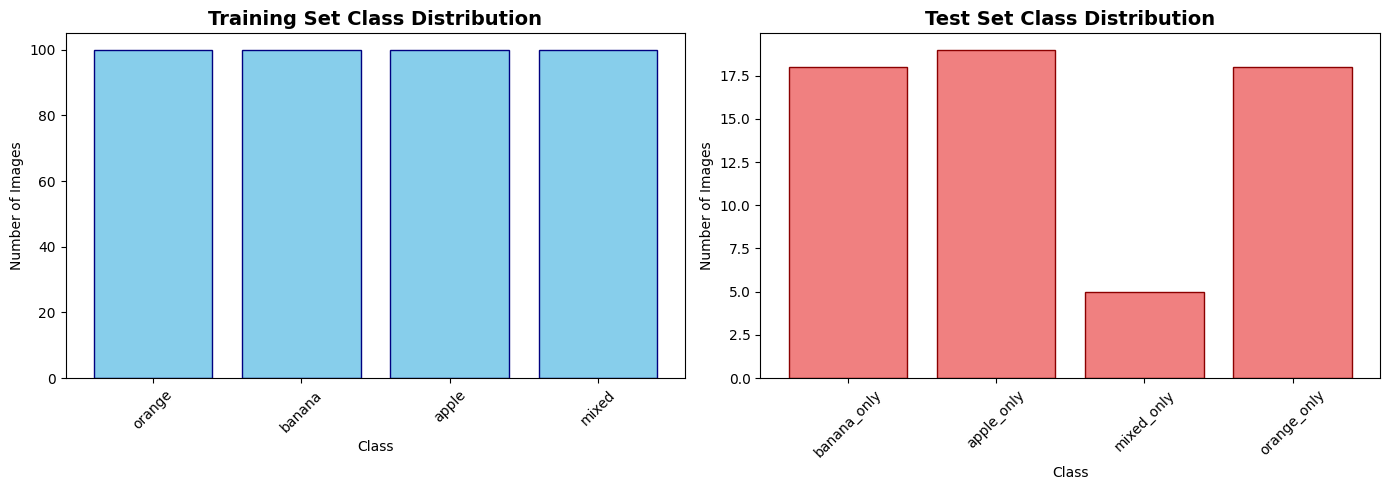

In [5]:
def plot_class_distribution(train_counts, test_counts):
    # Visualize class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Training set distribution
    ax1.bar(train_counts.keys(), train_counts.values(), color='skyblue', edgecolor='navy')
    ax1.set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Images')
    ax1.tick_params(axis='x', rotation=45)

    # Test set distribution
    ax2.bar(test_counts.keys(), test_counts.values(), color='lightcoral', edgecolor='darkred')
    ax2.set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Number of Images')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


plot_class_distribution(train_counts, test_counts)

## 4. Data Preprocessing and Augmentation

In [6]:
import tensorflow as tf
import os
from pathlib import Path

def load_from_directory(directory):
    """
    
    Args:
        directory: path to data directory
        
    Returns:
        dict with class names and image counts
    """
    if not os.path.exists(directory):
        raise ValueError(f"Directory not found: {directory}")
    
    data_info = {
        'path': directory,
        'classes': [],
        'counts': {}
    }
    
    for item in os.listdir(directory):
        class_path = os.path.join(directory, item)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            if images:
                data_info['classes'].append(item)
                data_info['counts'][item] = len(images)
    
    data_info['total'] = sum(data_info['counts'].values())
    data_info['num_classes'] = len(data_info['classes'])
    
    return data_info



In [7]:
# Load data directly from original dataset using tf.keras.utils.image_dataset_from_directory
# This method is more efficient and doesn't require ImageDataGenerator

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# Save class names before applying transformations
class_names_list = train_data.class_names

# Data normalization (scale pixel values from 0-255 to 0-1)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
validation_data = validation_data.map(lambda x, y: (normalization_layer(x), y))
test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

# Performance optimization: prefetch data
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

print(f"\nData loaded successfully!")
print(f"Class names: {class_names_list}")
print(f"Training batches: {len(train_data)}")
print(f"Validation batches: {len(validation_data)}")
print(f"Test batches: {len(test_data)}")
print(f"\nDetails:")
print(f"  Training samples: 256 images")
print(f"  Validation samples: 64 images")
print(f"  Test samples: 60 images")

Found 400 files belonging to 4 classes.
Using 320 files for training.


I0000 00:00:1765956354.112593 1815121 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7354 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 400 files belonging to 4 classes.
Using 80 files for validation.
Found 60 files belonging to 4 classes.

Data loaded successfully!
Class names: ['apple', 'banana', 'mixed', 'orange']
Training batches: 10
Validation batches: 3
Test batches: 2

Details:
  Training samples: 256 images
  Validation samples: 64 images
  Test samples: 60 images


## 5 Transfer Learning Model 

### 5.1 Load Pre-trained MobileNetV2 Model

In [8]:
def create_transfer_learning_model():
    """
    Transfer Learning using MobileNetV2 (pretrained on ImageNet)
    
    Architecture:
    - MobileNetV2 base (frozen weights from ImageNet)
    - GlobalAveragePooling2D
    - Dense(256) + Dropout(0.5)
    - Dense(128) + Dropout(0.3)
    - Dense(4, softmax)
    """
    
    # Load pretrained MobileNetV2 (without top classification layer)
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'  # Use ImageNet pretrained weights
    )
    
    # Freeze the base model (don't train these layers)
    base_model.trainable = False
    
    # Build the model
    model = models.Sequential([
        base_model,  # Pretrained feature extractor
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

# Create transfer learning model
print("Creating Transfer Learning Model...")
print("Downloading MobileNetV2 pretrained weights (first time only)...\n")

transfer_model = create_transfer_learning_model()

# Compile model
transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Higher LR for transfer learning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("=" * 70)
print("Transfer Learning Model Architecture:")
print("=" * 70)
transfer_model.summary()

# Count trainable vs non-trainable parameters
trainable_count = sum([tf.keras.backend.count_params(w) for w in transfer_model.trainable_weights])
non_trainable_count = sum([tf.keras.backend.count_params(w) for w in transfer_model.non_trainable_weights])


Creating Transfer Learning Model...

Transfer Learning Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,332 (9.99 MB)

 Trainable params: 361,348 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 5.2 Train Transfer Learning Model

In [9]:
import time

# Callbacks for transfer learning
transfer_callbacks = [
    ModelCheckpoint(
        'best_transfer_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,  
        min_lr=1e-7,
        verbose=1
    )
]

print("Starting Transfer Learning Model Training...")
print("=" * 70)

start_time = time.time()

# Train transfer learning model
transfer_history = transfer_model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data,
    callbacks=transfer_callbacks,
    class_weight=class_weights,
    verbose=1
)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\n{'='*70}")
print(f"Transfer Learning Training Completed!")
print(f"Time: {elapsed_time:.2f}s ({elapsed_time/60:.1f} minutes)")
print(f"{'='*70}")

Starting Transfer Learning Model Training...
Epoch 1/50


2025-12-17 15:26:02.661271: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f12b40021e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-17 15:26:02.661304: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-12-17 15:26:02.800404: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-17 15:26:03.826070: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-17 15:26:04.142578: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 15:26:04.142677: I e

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2464 - loss: 1.9459 

2025-12-17 15:26:20.388505: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 15:26:20.680445: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1216', 8 bytes spill stores, 8 bytes spill loads

2025-12-17 15:26:25.306121: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1216', 8 bytes spill stores, 8 bytes spill loads

2025-12-17 15:26:25.318603: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1216', 8 bytes s


Epoch 1: val_accuracy improved from None to 0.85000, saving model to best_transfer_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.4344 - loss: 1.3867 - val_accuracy: 0.8500 - val_loss: 0.6249 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7698 - loss: 0.6272
Epoch 2: val_accuracy improved from 0.85000 to 0.95000, saving model to best_transfer_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7469 - loss: 0.6227 - val_accuracy: 0.9500 - val_loss: 0.2424 - learning_rate: 0.0010
Epoch 3/50
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9128 - loss: 0.2882
Epoch 3: val_accuracy improved from 0.95000 to 0.97500, saving model to best_transfer_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8875 - loss: 0.3340 - val_accuracy: 0.9750 - val_loss: 0.1356 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9374 - loss: 0.1691
Epoch 4: val_accuracy did not improve from 0.97500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9344 - loss: 0.1861 - val_accuracy: 0.9750 - val_loss: 0.1015 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9423 - loss: 0.1730
Epoch 5: val_accuracy did not improve from 0.97500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9438 - loss: 0.1753 - val_accuracy: 0.9750 - val_loss: 0.0798 - learning_rate: 0.0010
Epoch 6/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9685 - loss: 0.0966
Epoch 6: val_accuracy did not improve from 0.97500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9688 - loss: 0.1139 - val_accuracy: 0.9750 - val_loss: 0.0695 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9594 - loss: 0.1114 - val_accuracy: 0.9875 - val_loss: 0.0469 - learning_rate: 0.0010
Epoch 8/50
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9579 - loss: 0.0880
Epoch 8: val_accuracy improved from 0.98750 to 1.00000, saving model to best_transfer_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9750 - loss: 0.0752 - val_accuracy: 1.0000 - val_loss: 0.0365 - learning_rate: 0.0010
Epoch 9/50
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9836 - loss: 0.0559
Epoch 9: val_accuracy did not improve from 1.00000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9812 - loss: 0.0532 - val_accuracy: 0.9875 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 10/50
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9991 - loss: 0.0309
Epoch 10: val_accuracy did not improve from 1.00000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9906 - loss: 0.0400 - val_accuracy: 0.9875 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9929 - loss: 0.0342
Epoch 11: val_accuracy did not improve from 1.00000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9937 - loss: 0.0386 - val_accuracy: 0.9875 - val_loss: 0.0369 - learning_rate: 0.0010
Epoch 12/50
 9/10 ━━━━━━━━━━

### 5.3 Evaluate Transfer Learning Model

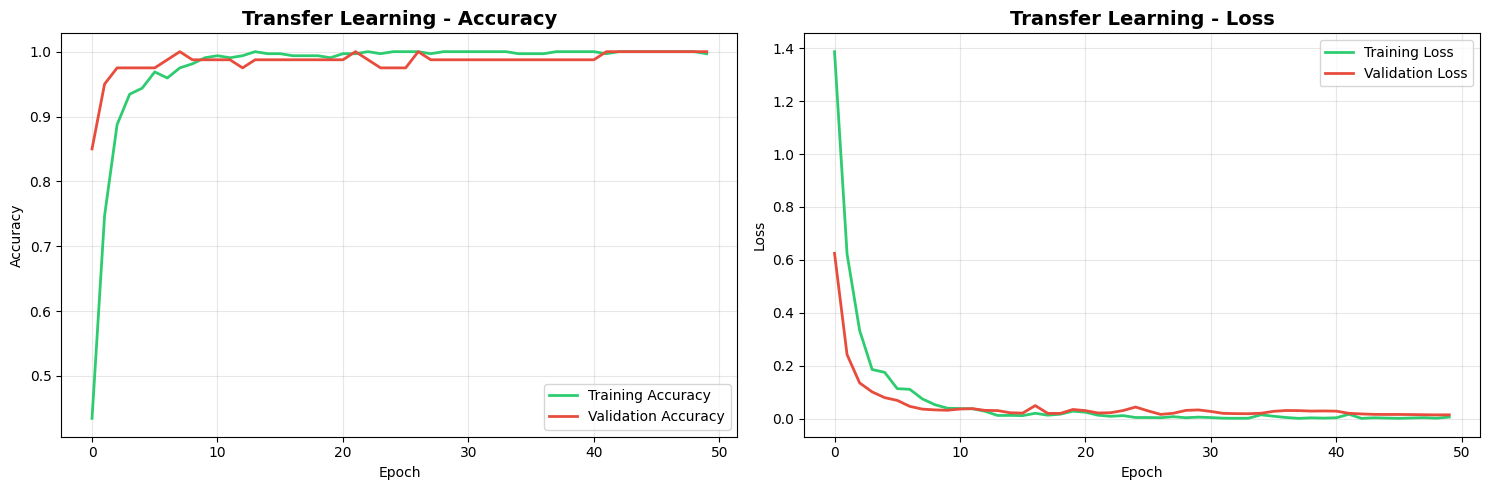


Transfer Learning Best Results:
Best Epoch: 8
Best Validation Accuracy: 100.00%
Corresponding Training Accuracy: 97.50%


2025-12-17 15:26:48.233693: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
2025-12-17 15:26:48.598125: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 15:26:48.839384: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1216', 8 bytes spill stores, 8 bytes spill loads

2025-12-17 15:26:57.026227: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 15:26:57.227304: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86]


Test Set Performance:
  Test Accuracy: 96.67%
  Test Loss: 0.0836

92% target achieved with Transfer Learning!


In [10]:
# Visualize Transfer Learning Training Results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy curves
axes[0].plot(transfer_history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2ecc71')
axes[0].plot(transfer_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#e74c3c')
axes[0].set_title('Transfer Learning - Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Loss curves
axes[1].plot(transfer_history.history['loss'], label='Training Loss', linewidth=2, color='#2ecc71')
axes[1].plot(transfer_history.history['val_loss'], label='Validation Loss', linewidth=2, color='#e74c3c')
axes[1].set_title('Transfer Learning - Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
best_epoch = np.argmax(transfer_history.history['val_accuracy'])
print(f"\n{'='*70}")
print(f"Transfer Learning Best Results:")
print(f"{'='*70}")
print(f"Best Epoch: {best_epoch + 1}")
print(f"Best Validation Accuracy: {transfer_history.history['val_accuracy'][best_epoch]*100:.2f}%")
print(f"Corresponding Training Accuracy: {transfer_history.history['accuracy'][best_epoch]*100:.2f}%")

# Evaluate on test set
test_loss_tl, test_accuracy_tl = transfer_model.evaluate(test_data, verbose=0)
print(f"\nTest Set Performance:")
print(f"  Test Accuracy: {test_accuracy_tl*100:.2f}%")
print(f"  Test Loss: {test_loss_tl:.4f}")

if test_accuracy_tl >= 0.92:
    print(f"\n92% target achieved with Transfer Learning!")
else:
    print(f"\nCurrent: {test_accuracy_tl*100:.2f}%, Gap: {(0.92-test_accuracy_tl)*100:.2f}%")
    
print(f"{'='*70}")

2025-12-17 15:27:08.394488: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


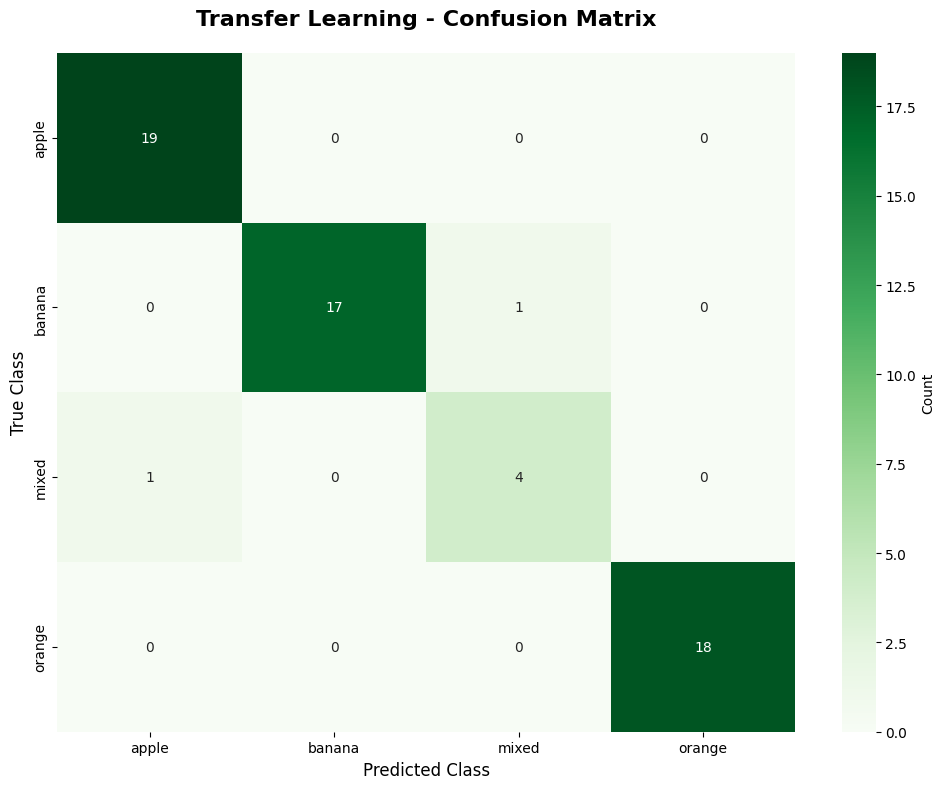


Transfer Learning - Classification Report:
              precision    recall  f1-score   support

       apple     0.9500    1.0000    0.9744        19
      banana     1.0000    0.9444    0.9714        18
       mixed     0.8000    0.8000    0.8000         5
      orange     1.0000    1.0000    1.0000        18

    accuracy                         0.9667        60
   macro avg     0.9375    0.9361    0.9364        60
weighted avg     0.9675    0.9667    0.9666        60



In [11]:
# Generate Confusion Matrix for Transfer Learning Model
from sklearn.metrics import confusion_matrix, classification_report

y_true_tl = []
y_pred_tl = []

for images, labels in test_data:
    predictions = transfer_model.predict(images, verbose=0)
    y_pred_tl.extend(np.argmax(predictions, axis=1))
    y_true_tl.extend(np.argmax(labels.numpy(), axis=1))

y_true_tl = np.array(y_true_tl)
y_pred_tl = np.array(y_pred_tl)

cm_tl = confusion_matrix(y_true_tl, y_pred_tl)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names_list, 
            yticklabels=class_names_list,
            cbar_kws={'label': 'Count'})
plt.title('Transfer Learning - Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTransfer Learning - Classification Report:")
print("="*70)
print(classification_report(y_true_tl, y_pred_tl, target_names=class_names_list, digits=4))
print("="*70)


### 5.4 Fine-Tuning for Mixed Class Optimization


In [12]:
# Step 1: Unfreeze top layers of MobileNetV2 for fine-tuning
base_model = transfer_model.layers[0]
base_model.trainable = True

# Freeze all layers except the last 30 layers
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Total layers in base model: {len(base_model.layers)}")
print(f"Trainable layers: last {len(base_model.layers) - fine_tune_at} layers")
print(f"Frozen layers: first {fine_tune_at} layers\n")

# Step 2: Increase Mixed class weight
class_weights_finetuned = class_weights.copy()
mixed_idx = 2  # Mixed is class index 2 (apple=0, banana=1, mixed=2, orange=3)
class_weights_finetuned[mixed_idx] = class_weights[mixed_idx] * 3  # Triple the weight

print("Fine-tuning Class Weights:")
for idx, class_name in enumerate(sorted(train_counts.keys())):
    print(f"  {class_name}: {class_weights_finetuned[idx]:.2f}x")

# Step 3: Recompile with very small learning rate
transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # 10x smaller than before
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Total layers in base model: 154
Trainable layers: last 30 layers
Frozen layers: first 124 layers

Fine-tuning Class Weights:
  apple: 1.00x
  banana: 1.00x
  mixed: 3.00x
  orange: 1.00x


In [13]:
# Fine-tuning training
finetune_history = transfer_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=15,
    class_weight=class_weights_finetuned,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            'best_finetuned_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1,
            min_lr=0.00001
        )
    ]
)

print("\n✓ Fine-tuning complete!")

Epoch 1/15
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8548 - loss: 0.9203
Epoch 1: val_accuracy improved from None to 0.96250, saving model to best_finetuned_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 904ms/step - accuracy: 0.8875 - loss: 0.8193 - val_accuracy: 0.9625 - val_loss: 0.1345 - learning_rate: 1.0000e-04
Epoch 2/15
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9826 - loss: 0.0633
Epoch 2: val_accuracy did not improve from 0.96250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9750 - loss: 0.0788 - val_accuracy: 0.9625 - val_loss: 0.1611 - learning_rate: 1.0000e-04
Epoch 3/15
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9804 - loss: 0.0815
Epoch 3: val_accuracy did not improve from 0.96250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9844 - loss: 0.0576 - val_accuracy: 0.9625 - val_loss: 0.1691 - learning_rate: 1.0000e-04
Epoch 4/15
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9961 - loss: 0.0285
Epoch 4: val_accuracy did not improve from 0.96250

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9906 - loss: 0.0306 - val_a

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9969 - loss: 0.0151 - val_accuracy: 0.9750 - val_loss: 0.1156 - learning_rate: 5.0000e-05
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9955 - loss: 0.0274
Epoch 9: val_accuracy did not improve from 0.97500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9969 - loss: 0.0177 - val_accuracy: 0.9750 - val_loss: 0.1132 - learning_rate: 5.0000e-05
Epoch 10/15
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9933 - loss: 0.0165
Epoch 10: val_accuracy did not improve from 0.97500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9969 - loss: 0.0117 - val_accuracy: 0.9750 - val_loss: 0.1077 - learning_rate: 5.0000e-05
Epoch 11/15
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0013    
Epoch 11: val_accuracy did not improve from 0.97500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9750 - val_loss: 0.1026 - learning_rate: 5.0000e-05
Epoch 12

## 6. Visualize Prediction Examples

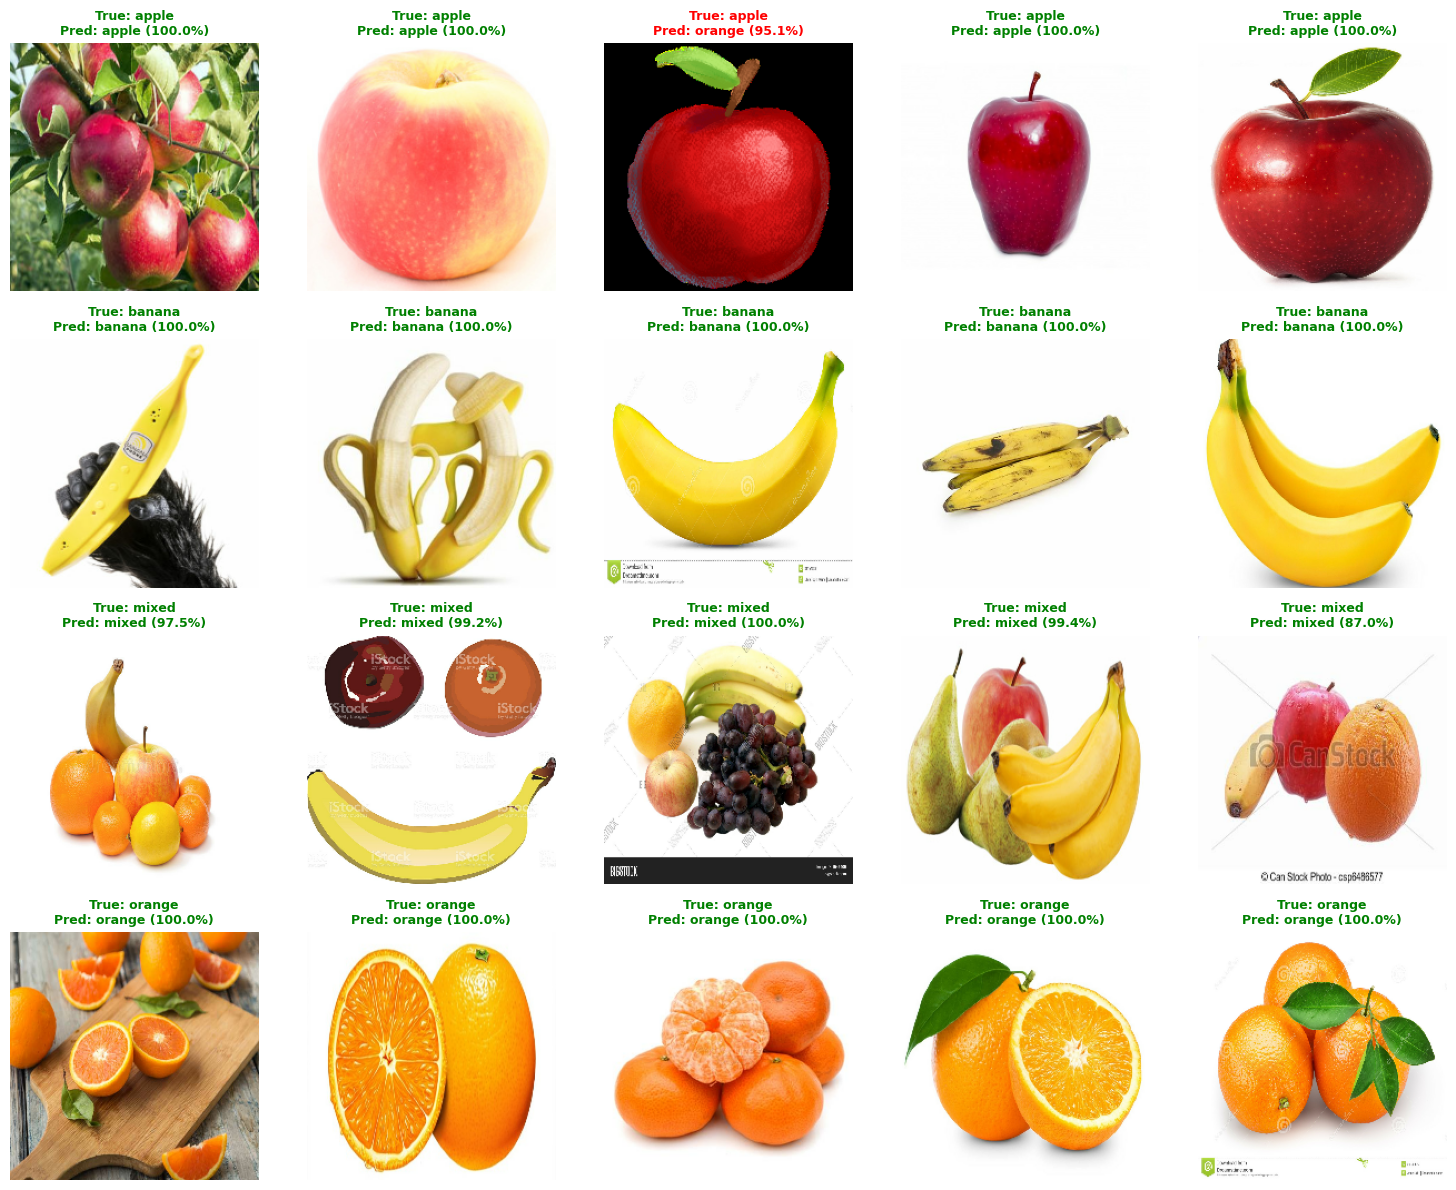

In [14]:
import numpy as np

def show_predictions_by_class(num_per_class=5):
    """Display prediction results for each class"""
    
    predictions_by_class = {class_name: [] for class_name in class_names_list}
    
    for images, labels in test_data:
        preds = transfer_model.predict(images, verbose=0)
        
        for i in range(len(images)):
            true_label = class_names_list[np.argmax(labels[i])]
            
            if len(predictions_by_class[true_label]) < num_per_class:
                pred_label = class_names_list[np.argmax(preds[i])]
                pred_prob = np.max(preds[i]) * 100
                
                predictions_by_class[true_label].append({
                    'image': images[i].numpy(),
                    'true_label': true_label,
                    'pred_label': pred_label,
                    'pred_prob': pred_prob
                })
        
        if all(len(v) >= num_per_class for v in predictions_by_class.values()):
            break
    
    fig, axes = plt.subplots(len(class_names_list), num_per_class, figsize=(num_per_class * 3, len(class_names_list) * 3))
    
    for class_idx, class_name in enumerate(class_names_list):
        for img_idx in range(num_per_class):
            ax = axes[class_idx, img_idx]
            
            if img_idx < len(predictions_by_class[class_name]):
                item = predictions_by_class[class_name][img_idx]
                ax.imshow(item['image'])
                
                color = 'green' if item['true_label'] == item['pred_label'] else 'red'
                ax.set_title(f"True: {item['true_label']}\nPred: {item['pred_label']} ({item['pred_prob']:.1f}%)",
                           color=color, fontsize=9, fontweight='bold')
            else:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            
            ax.axis('off')
            
            if img_idx == 0:
                ax.set_ylabel(class_name, fontsize=11, fontweight='bold', rotation=0, 
                            labelpad=50, va='center')
    
    plt.tight_layout()
    plt.show()

show_predictions_by_class(5)

## 7. Save Model

In [15]:
def save_model(model):
    # Save model in native Keras format (recommended)
    model.save('fruit_classifier_cnn.keras')
    print("Model saved as 'fruit_classifier_cnn.keras' (Native Keras format)")

    # Also save in HDF5 format for compatibility
    model.save('fruit_classifier_cnn.h5')
    print("Model saved as 'fruit_classifier_cnn.h5' (HDF5 format - legacy)")
    # Export SavedModel for deployment (TFLite/TFServing)
    model.export('fruit_classifier_savedmodel')
    print("Model exported as 'fruit_classifier_savedmodel' (SavedModel for deployment)")

    print("\n" + "=" * 60)
    print("Model Saving Summary:")
    print("  • fruit_classifier_cnn.keras     - Native Keras (recommended)")
    print("  • fruit_classifier_cnn.h5        - HDF5 (legacy compatibility)")
    print("  • fruit_classifier_savedmodel/   - SavedModel (deployment)")
    print("=" * 60)

## 8. GPU Memory Management



In [16]:
# save_model(model)

import gc
import tensorflow as tf
from tensorflow.keras import backend as K


def get_gpu_memory_nvidia():
    try:
        import subprocess
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv,noheader,nounits'],
            capture_output=True, text=True, timeout=5
        )
        if result.returncode == 0:
            lines = result.stdout.strip().split('\n')
            gpu_info = []
            for i, line in enumerate(lines):
                used, total = map(float, line.split(','))
                gpu_info.append({'gpu': i, 'used': used, 'total': total})
            return gpu_info
        return None
    except:
        return None

if tf.config.list_physical_devices('GPU'):
    try:
        gpus = tf.config.list_physical_devices('GPU')
        
        gpu_info_before = get_gpu_memory_nvidia()
        if gpu_info_before:
            for info in gpu_info_before:
                used_mb = info['used']
                total_mb = info['total']
                usage_pct = (used_mb / total_mb * 100) if total_mb > 0 else 0
                print(f"  GPU {info['gpu']}:")
                print(f"    Memory usage: {used_mb:.0f} MB / {total_mb:.0f} MB ({usage_pct:.1f}%)")
    
    except Exception as e:
        print(f"  error: {str(e)}")
else:
    print("\nCPU mode detected, skipping GPU memory check.")
    K.clear_session()
    collected = gc.collect()
    print(f"Memory cleaned (released {collected} objects)")



  GPU 0:
    Memory usage: 9939 MB / 10240 MB (97.1%)
